# Inference
> Making predictions on new data

In this notebook we move to the process of making predictions. As mentioned in other places, one of the aims of `nnanno` was to show a *possible* way of using computer vision/deep learning without requiring unconstrained resources. This notebook tries to demo this approach in action. This notebook was all run on Google Colab  *full disclaimer* I have a 'pro' account which bumps up the maximum run time but this approach will work on the free version of Colab too. 

In [ ]:
# all_slow

If you are running this on colab you can run this cell to mount your drive. Saving progress on Colab can be a bit annoying but it's simple to store things in Google Drive. This means you can avoid reloading data every time you interact with Colab and also allows you to save the progress of your model so you don't have to retrain a model multiple times. 

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# TODO update install cell when uploaded to pypi/github

In [ ]:
# TODO download data cell

In [ ]:
!pip install ./nnanno/.

Install fastai. The latest version is likely to be fine but if there is a breaking change to fastai you can use the pinned version. 

In [ ]:
!pip install fastai -U
#!pip install fastai==2.2.5

For reference the version of fastai used for this notebook

In [ ]:
import fastai

fastai.__version__

'2.2.5'

Check that we have cuda available (GPU). If this returns false click on 'runtime' and choose 'change runtime type' and choose GPU acceleration 

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
from pathlib import Path

import pandas as pd
from fastai.vision.all import *

In [ ]:
# path = Path("/content/drive/MyDrive/Models/nnanno_all_years/data/")

So far in this series of example notebooks we have used square resizing on all of our images. This maybe okay but since newspapers images tend to be more vertical it might be worth considering a different way of resizing. We can use a handy helper function `get_image_files` to grab all of our images

In [ ]:
images = get_image_files(path / "images")

This function returns the image paths wrapped in an `L` instance. `L` is essentially a fancy Python list that includes some extra goodies. See the [fastcore docs](https://fastcore.fast.ai/#L) for a fuller explanation. 

We'll use `map` to go through our images, load them, grab the shape and then calculate the average ratio

In [ ]:
images.map(lambda x: load_image(x).shape).map(lambda x: x[0] / x[1]).sum() / len(images)

1.6800333981201243

In [ ]:
256 * 1.68

430.08

We'll use this ratio to reshape our images. This won't always make sense but if for example you are working with photos of a standard size, or film clips with a consistent aspect ratio it makes sense to batch them in this way. 

In [ ]:
df = pd.read_json(first(path.rglob("images/*.json")))
df.pub_date = pd.to_datetime(df.pub_date)

Most of the next cells are the same as in our previous notebook. The main thing we change is that we use a non square size for our transform. 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
valid, train = train_test_split(df.copy(), train_size=0.4, stratify=df.pub_date.dt.year)

In [ ]:
train["is_valid"] = False
valid["is_valid"] = True

In [ ]:
df = pd.concat([train, valid])

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
full_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(),
    get_x=ColReader("download_image_path", pref=path / "images/"),
    get_y=ColReader("label"),
    item_tfms=Resize((1024), ResizeMethod.Squish),
    batch_tfms=[
        *aug_transforms(size=(430, 256), max_rotate=0.01, max_warp=0.0),
        Normalize.from_stats(*imagenet_stats),
    ],
)

Once we have created our `DataBlock` we use the `dataloaders` method to load our data. 

In [ ]:
dls = full_data.dataloaders(df, bs=32, num_workers=2)

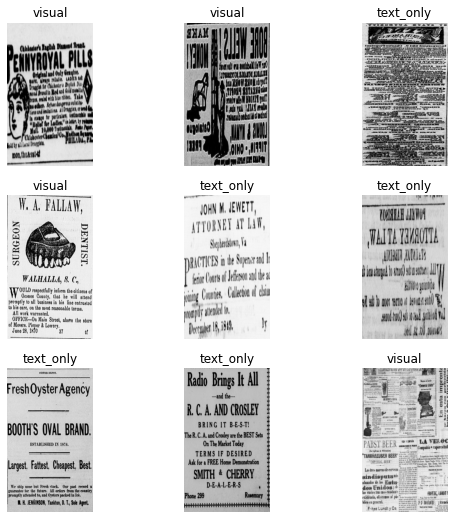

In [ ]:
dls.show_batch()

We can see that this time our images are no longer square. 

## Training our model

Now we get to training our model, again we define some metrics we want to track

In [ ]:
metrics = [F1Score(average="weighted"), Precision(), Recall(), accuracy]

### Choosing a model 

There are various things we might care about when choosing a model. These include (but are not limited to):

- performance
- memory usage
- how data-hungry the model is
- training speed
- inference speed

Since we have committed to working with relatively constrained resources, we might want to try a model architecture with lower resource requirements. A smaller model should help speed up inference. One option is a variant of `squeezenet`.

The title of the paper [*SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size*](https://arxiv.org/abs/1602.07360) already tell us that this model aims to perform with more constrained resources. Another paper, [*Benchmark Analysis of Representative Deep Neural Network Architectures*](https://ieeexplore.ieee.org/document/8506339) gives some comparisons between a range of computer vision model architectures. Of particular interest here is that inference speed comparison.

![](https://gist.githubusercontent.com/davanstrien/875d36c651440e85f029605e9b43187c/raw/f07482435d8d9a9c6648740b2077d2d1299f9e4b/squeeze.png)
[Source](https://arxiv.org/pdf/1810.00736.pdf)

We might have to trade some performance in termes of accuracy for speed, let's see how this model does

In [ ]:
learn = cnn_learner(
    dls, squeezenet1_0, loss_func=LabelSmoothingCrossEntropy(), metrics=metrics
)

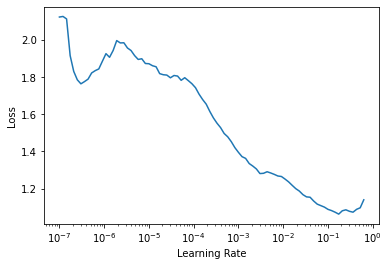

In [ ]:
min, steep = learn.lr_find()

In [ ]:
learn.fine_tune(
    30,
    base_lr=1e-2,
    cbs=[
        EarlyStoppingCallback(monitor="f1_score", patience=5),
        ReduceLROnPlateau(monitor="f1_score", patience=4),
        SaveModelCallback(monitor="f1_score"),
        MixUp(),
    ],
)

epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,accuracy,time
0,0.973779,0.667897,0.874916,0.780347,0.888158,0.873272,00:46


Better model found at epoch 0 with f1_score value: 0.8749156386297715.


epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,accuracy,time
0,0.683483,0.513597,0.861393,0.905172,0.690789,0.866359,00:47
1,0.624809,0.406790,0.902761,0.876712,0.842105,0.903226,00:46
2,0.598961,0.346350,0.924020,0.888889,0.894737,0.923963,00:46
3,0.560721,0.427729,0.896110,0.928571,0.769737,0.898618,00:47
4,0.531082,0.413794,0.891139,0.927419,0.756579,0.894009,00:48
5,0.520971,0.523305,0.880350,0.756477,0.960526,0.877880,00:47
6,0.516447,0.339545,0.914604,0.975410,0.782895,0.917051,00:47
7,0.495297,0.405797,0.845256,0.958763,0.611842,0.854839,00:48


Better model found at epoch 0 with f1_score value: 0.8613928055574661.
Better model found at epoch 1 with f1_score value: 0.9027609074645914.
Better model found at epoch 2 with f1_score value: 0.9240202559406454.
Epoch 6: reducing lr to 0.0004509419154985572
No improvement since epoch 2: early stopping


The final performance we get isn't too bad so we'll continue using this model for our inference process. 

### Save our model

We may want to come back to our model later so we will use the 'export' function to save the model weights. We could also share this model with other people if we think it will be helpful to them. If we do this, we should be careful to make sure we document the model as much as possible. 

In [ ]:
learn.path = path

In [ ]:
learn.export()

## Inference

We're now ready to do inference. We'll start by importing the inference module from nnanno

In [ ]:
from nnanno.inference import *

We can load our previous learner

In [ ]:
learn = load_learner(path / "export.pkl")

In [ ]:
learn

I've had the odd issue with running inference if the dls isn't set expliclty. This is something to look into properly... \ # TODO diagnose dls inference issues 

In [ ]:
learn.dls = dls

We now create an instance of `nnPredict` and pass in our learner and a flag to use the GPU

In [ ]:
predict = nnPredict(learn, try_gpu=True)

In [ ]:
predict

nnPredict 
learner vocab:['text_only', 'visual']

We'll create a new folder for storing our inference outputs

In [ ]:
Path(path / "inference").mkdir(exist_ok=True)


#### How to sample?

When we created a sample for generating training data we sampled a (roughly) an equal number of images for each decade. We did this because we wanted our model to be equally good for all decades we're looking at. We evaluated in the previous notebook.

Now we are turning to predict on the dataset we might have different criteria. Since we are looking to explore trends across a broad time (1850-1950), we will replicate our strategy from our initial sample of taking snapshots every ten years. One thing we will change this time is to sample a certain percentage from each decade rather than taking a fixed amount. This will allow us to see the relative presence of visual vs non-visual ads for each year as well as underlying changes in the dataset in terms of total numbers. 

Going through our other parameters, `ads` is the class we want to predict. 
`out_dir` is the folder where we'll store the predictions. These predictions consist of the rows from the original newspaper navigator dataset with extra columns for the predicted classes. We'll explore this output in more detail in subsequent notebooks. 

`bs` is the size of each batch we want to use for inference. `nnanno` will grab a batch of 64 images at a time and then pass this to the GPU (if using the GPU). 

The  `sample_size` is the size of our sample as a float (percentage). We could also pass in a specific value. `step` is the step between years, in this case, every ten years. Size is used to form the iiif request. We can use the IIIF URL request to send us a certain sized image. By default, this will try and get the size as close as possible to this *without* warping the image. This means we only send the size of the image required. `force_dir` is a flag that can be used to stop nnanno complaining if you are using a non-empty directory to store your annotations. Usually, this check is there to help you avoid overwritting predictions accidently. However, it's often useful to get a sense for how long things are going to take. When we start the `predict_sample` method we will see two progress bars. The top progress bar shows the total progress through the entire sample. The secoond progress bar shows you the progrss through each batch. If a sample for a particular year fits into less than one batch, the second progress bar won't show for that batch. We can use this progress bar to quite quickly give a sense of how long our full requested sample will take. We can then use this to adjust the size of our sample if necessary. 


## Considerations 
As pointed out in other parts of the documentation nnano is intended to help smaller samples of the newspaper navigator dataset. Although IIIF can handle large request loads, we should still be considerate. If you want to predict the entire dataset, the newspaper navigator data is also available via an [s3 bucket](news-navigator.labs.loc.gov/). 


In [ ]:
predict.predict_sample(
    "ads",
    out_dir=path / "inference",
    bs=64,
    sample_size=0.003,
    step=10,
    size=(430, 256),
    force_dir=True,
)

Now is a good time to get a coffee or have a nap...

For these long running jobs in Colab you may occassionaly deal with timeouts or getting kicked off Colab. This is one of the trade-offs for getting something 'free'. This is why it's good to save the results of training and inference as you go so it's easier to pickup where you left off. For example making sure you save to a Google Drive folder (or a mounted s3 bucket etc.). In the next notebook we'll start to explore our predictions 😀

fin